In [20]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Julia/tut2/b`


## Parametric Regression

In [21]:
using Flux 
using Plots
using LinearAlgebra

function setup_model()
    model = Chain(Dense(1 => 1, Flux.relu), Dense(1 => 1, sum), only)
    set_weights!(model, [0; 0; 1; 1])

    return model
end

function get_weights(model)
    b0 = model.layers[1].bias[1]
    b1 = model.layers[2].bias[1]
    w0 = model.layers[1].weight[1]
    w1 = model.layers[2].weight[1]

    return [b0; b1; w0; w1]
end

function set_weights!(model, weights)
    model.layers[1].bias[1] = weights[1]
    model.layers[2].bias[1] = weights[2]
    model.layers[1].weight[1] = weights[3]
    model.layers[2].weight[1] = weights[4]

    return
end

function model_error(model, x, y)
    x = only(x)
    b0, b1, w0, w1 = get_weights(model)
    r = relu(w0 * x + b0)
    r > 0 ? ∇r = 1 : ∇r = 0
    e = w1 * r + b1 - y

    return e, r, ∇r
end

function model_loss(model, data)
    loss = 0
    for data_point in data
        loss += 0.5 * model_error(model, data_point...)[1]^2
    end
    
    return loss
end

plot_model(model) = plot(x -> model([x]), -2:0.1:2)
plot_model!(model) = plot!(x -> model([x]), -2:0.1:2)
plot_progress(errors) = plot(errors, yaxis=:log)
plot_progress!(errors) = plot!(errors, yaxis=:log)

data = [([-1.0], 2.0), ([1.0], 2.0)]

2-element Vector{Tuple{Vector{Float64}, Float64}}:
 ([-1.0], 2.0)
 ([1.0], 2.0)

### 1.1 c)  (gradient descent batched)

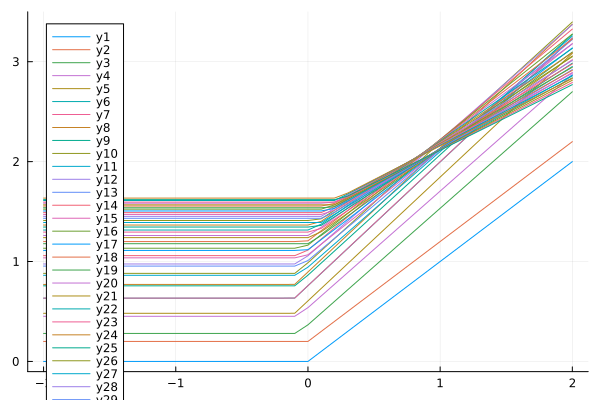

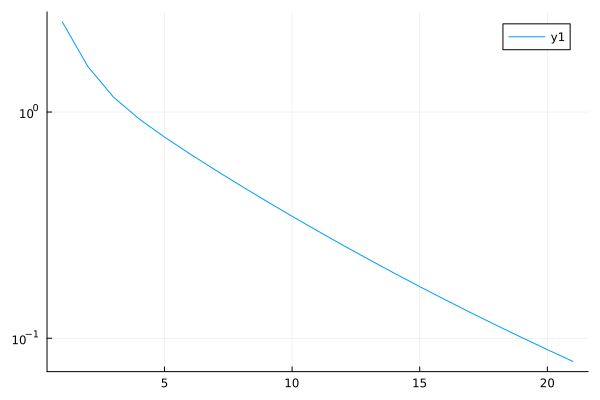

4-element Vector{Float32}:
 -0.19767115
  1.6192348
  0.8023289
  0.8181836

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 1, relu)
│   summary(x) = 1-element Vector{Float64}
└ @ Flux /home/victor/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


In [22]:
model = setup_model()
optim = Flux.setup(Descent(0.1), model)
epochs = 20
errors_batched = zeros(epochs+1)

model_plot = plot_model(model)

for epoch in 1:epochs
    errors_batched[epoch] = model_loss(model, data)
    for batch in 1:2
        Flux.train!((m,x,y) -> 0.5 * (m(x) - y)^2, model, [data[batch]], optim)
        model_plot = plot_model!(model)
    end
end
errors_batched[end] = model_loss(model, data)

progress_plot = plot_progress(errors_batched)

display(model_plot)
display(progress_plot)
display(get_weights(model))


### gradient descent non-batched

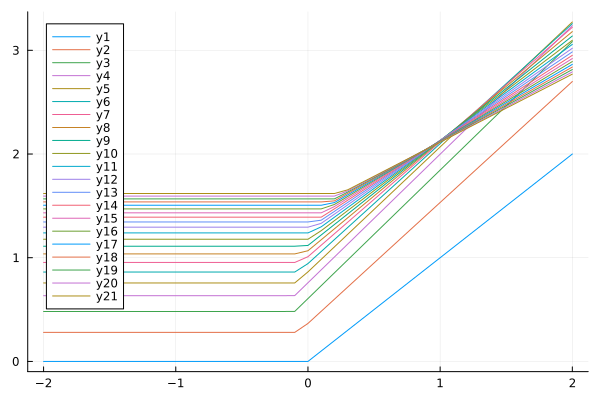

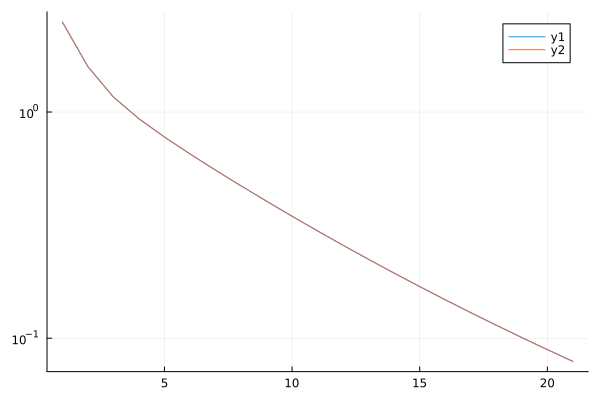

4-element Vector{Float32}:
 -0.19767115
  1.6192348
  0.8023289
  0.8181836

In [23]:
model = setup_model()
optim = Flux.setup(Descent(0.1), model)
epochs = 20
errors_nonbatched = zeros(epochs+1)

model_plot = plot_model(model)

for epoch in 1:epochs
    errors_nonbatched[epoch] = model_loss(model, data)
    Flux.train!((m,x,y) -> 0.5 * (m(x) - y)^2, model, data, optim)
    model_plot = plot_model!(model)
end
errors_nonbatched[end] = model_loss(model, data)

progress_plot = plot_progress(errors_batched)
progress_plot = plot_progress!(errors_nonbatched)

display(model_plot)
display(progress_plot)
display(get_weights(model))

### Adam batched

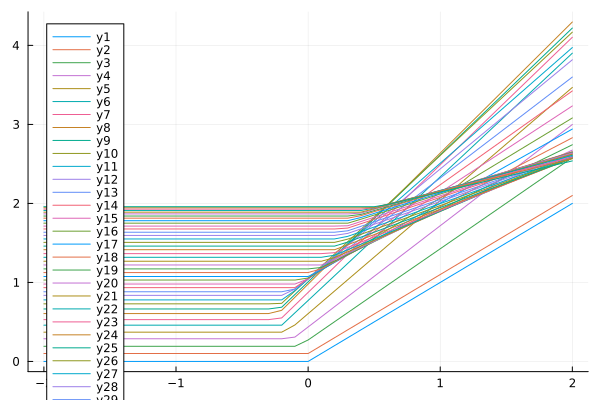

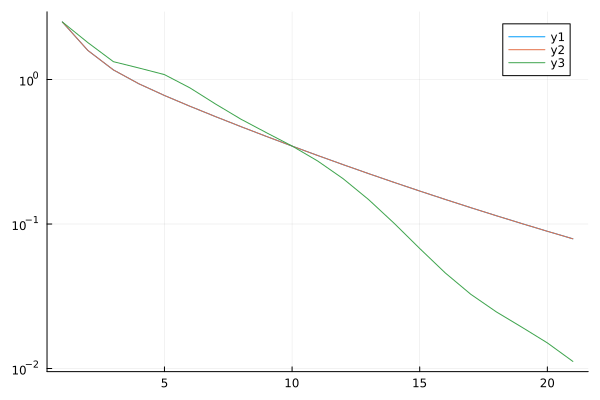

4-element Vector{Float32}:
 -0.34642458
  1.9584907
  0.6535755
  0.60324746

In [24]:
model = setup_model()
optim = Flux.setup(Adam(0.1), model)
epochs = 20
errors_adam_batched = zeros(epochs+1)

model_plot = plot_model(model)

for epoch in 1:epochs
    errors_adam_batched[epoch] = model_loss(model, data)
    for batch in 1:2
        Flux.train!((m,x,y) -> 0.5 * (m(x) - y)^2, model, [data[batch]], optim)
        model_plot = plot_model!(model)
    end
end
errors_adam_batched[end] = model_loss(model, data)

progress_plot = plot_progress(errors_batched)
progress_plot = plot_progress!(errors_nonbatched)
progress_plot = plot_progress!(errors_adam_batched)

display(model_plot)
display(progress_plot)
display(get_weights(model))


### Adam nonbatched

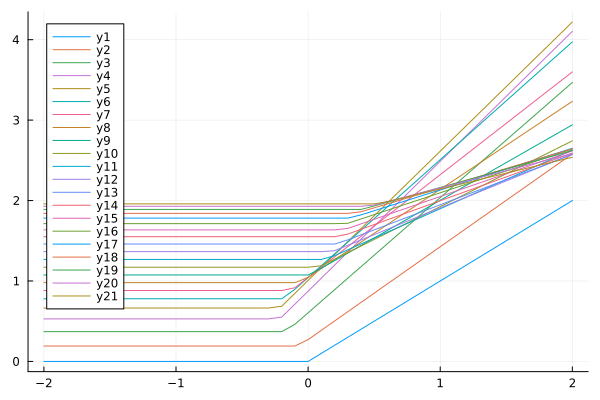

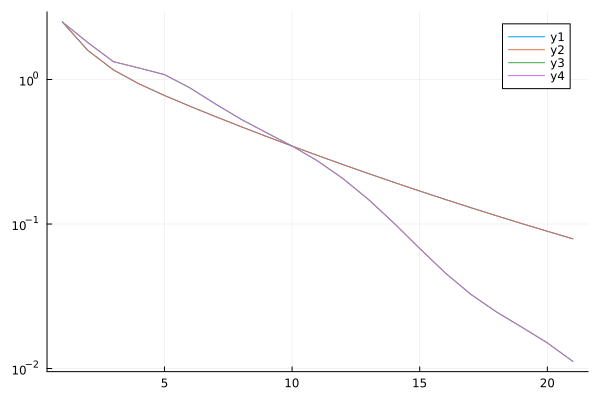

4-element Vector{Float32}:
 -0.34642458
  1.9584907
  0.6535755
  0.60324746

In [25]:
model = setup_model()
optim = Flux.setup(Adam(0.1), model)
epochs = 20
errors_adam_nonbatched = zeros(epochs+1)

model_plot = plot_model(model)

for epoch in 1:epochs
    errors_adam_nonbatched[epoch] = model_loss(model, data)
    Flux.train!((m,x,y) -> 0.5 * (m(x) - y)^2, model, data, optim)
    model_plot = plot_model!(model)
end
errors_adam_nonbatched[end] = model_loss(model, data)

progress_plot = plot_progress(errors_batched)
progress_plot = plot_progress!(errors_nonbatched)
progress_plot = plot_progress!(errors_adam_batched)
progress_plot = plot_progress!(errors_adam_nonbatched)

display(model_plot)
display(progress_plot)
display(get_weights(model))

### Newton batched

In [26]:
function gradient(model, x, y)
    x = only(x)
    b0, b1, w0, w1 = get_weights(model)
    e, r, ∇r = model_error(model, x, y)
    
    return [
        e * w1 * ∇r
        e
        e * w1 * ∇r * x
        e * r
    ]
end

function hessian(model, x, y;ϵ=1e-6)
    x = only(x)
    b0, b1, w0, w1 = get_weights(model)
    e, r, ∇r = model_error(model, x, y)
    
    return [
        w1^2*∇r^2     w1*∇r    w1^2*∇r^2*x       e*∇r+w1*r*∇r
        w1*∇r         1        w1*∇r*x           r
        w1^2*∇r^2*x   w1*∇r*x  w1^2*∇r^2*x^2     e*∇r*x+w1*r*∇r*x
        e*∇r+w1*r*∇r  e*r      e*∇r*x+w1*r*∇r*x  r^2
    ] + I*ϵ
end

function line_search!(model, data, sol; steps=10)
    weights_old = get_weights(model)
    loss_old = model_loss(model, data)

    for step in 1:steps
        step_factor = 0.5^(step-1)
        set_weights!(model,weights_old-step_factor*sol)
        loss = model_loss(model, data)
        loss < loss_old && break
    end
end

function newton!(model, data, batch; ϵ=1e-6, line_search_steps=10)
    x, y = data[batch]
    sol = hessian(model, x, y; ϵ)\gradient(model, x, y)

    line_search!(model, data, sol, steps=line_search_steps)
end

function newton!(model, data; ϵ=1e-6, line_search_steps=10)
    x1, y1 = data[1]
    x2, y2 = data[2]
    sol = (hessian(model, x1, y1; ϵ) + hessian(model, x2, y2; ϵ)) \ (gradient(model, x1, y1) + gradient(model, x2, y2))

    line_search!(model, data, sol, steps=line_search_steps)
end

newton! (generic function with 2 methods)

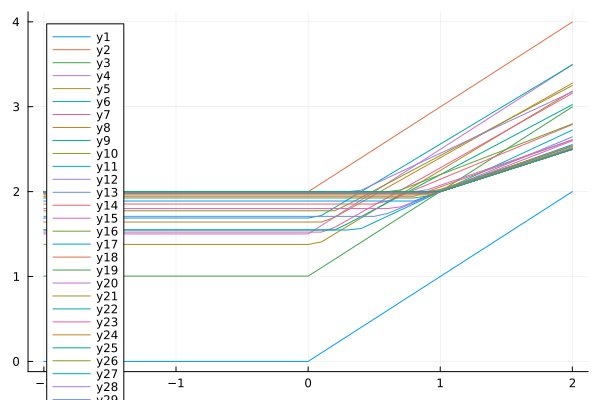

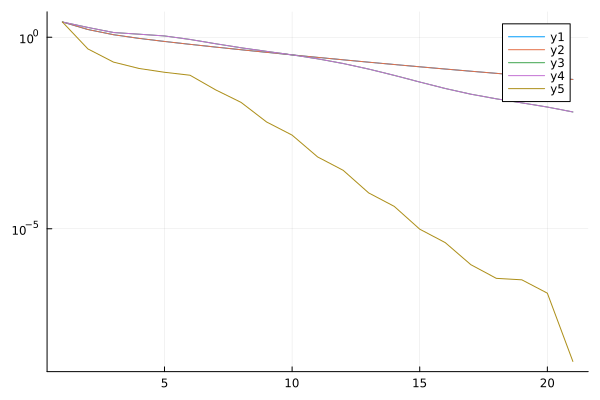

4-element Vector{Float32}:
 -0.49995837
  1.999917
  0.50004166
  0.99576265

In [27]:
model = setup_model()
epochs = 20
errors_newton_batched = zeros(epochs+1)

model_plot = plot_model(model)

for epoch in 1:epochs
    errors_newton_batched[epoch] = model_loss(model, data)
    for batch in 1:2
        newton!(model, data, batch; ϵ=1e-3, line_search_steps=5)
        model_plot = plot_model!(model)
    end
end
errors_newton_batched[end] = model_loss(model, data)

progress_plot = plot_progress(errors_batched)
progress_plot = plot_progress!(errors_nonbatched)
progress_plot = plot_progress!(errors_adam_batched)
progress_plot = plot_progress!(errors_adam_nonbatched)
progress_plot = plot_progress!(errors_newton_batched)

display(model_plot)
display(progress_plot)
display(get_weights(model))


### Newton non-batched

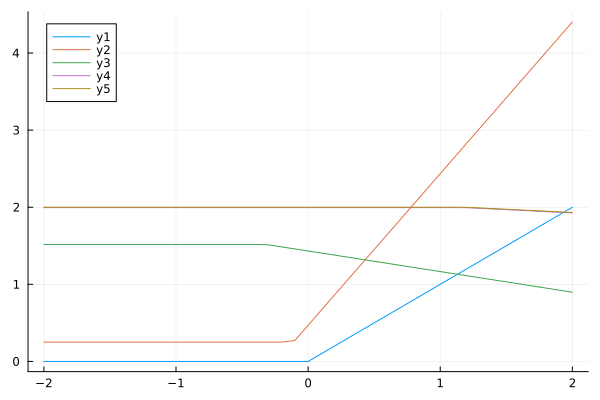

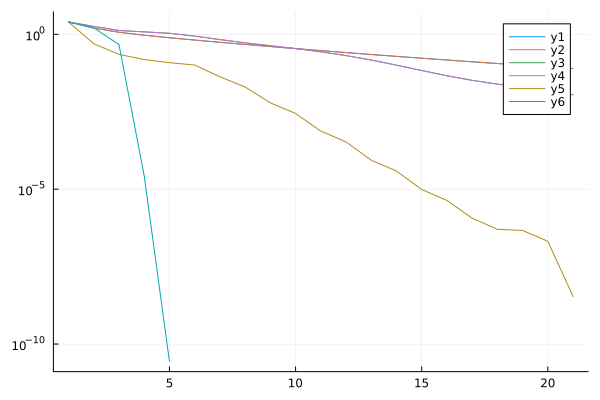

4-element Vector{Float32}:
 -0.54355186
  1.9999948
  0.4564482
 -0.18562071

In [28]:
model = setup_model()
epochs = 4
errors_newton_nonbatched = zeros(epochs+1)

model_plot = plot_model(model)

for epoch in 1:epochs
    errors_newton_nonbatched[epoch] = model_loss(model, data)
    newton!(model, data; ϵ=1e-3, line_search_steps=5)
    model_plot = plot_model!(model)
end
errors_newton_nonbatched[end] = model_loss(model, data)

progress_plot = plot_progress(errors_batched)
progress_plot = plot_progress!(errors_nonbatched)
progress_plot = plot_progress!(errors_adam_batched)
progress_plot = plot_progress!(errors_adam_nonbatched)
progress_plot = plot_progress!(errors_newton_batched)
progress_plot = plot_progress!(errors_newton_nonbatched)

display(model_plot)
display(progress_plot)
display(get_weights(model))